## A class acces_code and a class token to obtein users data from spotify web API:

In [1]:
#Import libraries for data manipulation and representation 
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#Import libraries for data visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns


#Import our catch_accesAndToken python script to create an instance of the acces_code and the token classes:
from catch_accesAndToken import acces_code, token

#Import libraries to interact with the spotify web API:
import requests
import json

#others
import warnings
warnings.filterwarnings("ignore")

In [2]:
my_access_codeAndToka, tokA = acces_code().get_acces_code(), token().get_token()

In [3]:
print('Access code:')
print(my_access_codeAndToka, '\n')
print('Token:')
print(tokA)

Access code:
AQBUdwmyoAbmB49moPhmM0PZPn0J63sGi69jNyPruX3nnfBiax9c-2cJvntcSf_5rkyg1sJqArhV1xYI-MLdlMeEuVayQSoNytkdj4UJVCWQgt-sT6l8Gs7XtXwi8Q7M6MoXwOrU2dAErKH3poFCAtrDWo55fTy9TCellX0zLLseLtbbpmTumA 

Token:
BQDq3LmvU-TghqyhdWtv-0xJSxVrluKVeHQrXeRfXeDANH3e6Pc-AeJb7ZpZjL-91wOnJbP0oM7r7le8MqsC7qq9P70Xh9PlpXxOZIH4ryo9rHjX9704eN8yqCDFKI5a3uOKJB-2SYcjddhef2RebiFLZf1G36_runYqSNgj3JYsUr9QUnYpxyl1DkYPURXS2JFag_2VOg


Once we obtain the users permission to access the data specified in the key **scopes** from the data_init.json, we can use the token to pull data from the spotify web API, in this case we are accessing the top 10 artists, tracks and genres listened by the user.

For making this possible we have to specified the url from where we are going to get the data, and the endpoint (or endpoints) in which the data is store:

In [4]:
consult_url = 'https://api.spotify.com/v1'
endpoint_user_topS ='/me/top/'
#adding to the endpoint the objects we want to retirve:
type_artist, type_track = 'artists', 'tracks'

Every request made to the API should include as an argument the follow:

* The complete URL (BASE URL + ENDPOINT)
* parameters
* headers

Look in the official documentation [Here](https://developer.spotify.com/documentation/web-api/)

For demonstration purposes we can established all headers as follow:

In [5]:
private_headers =  {'Authorization': f'Bearer {tokA}', 'Content-Type': 'application/json'}

In [6]:
#Consult the top Artist, Track and musical Genres from a user:
def my_tops (type_, headers, limit = 10, genres = False):
    '''Consult the top Artist, Track and musical Genres of a user base on a threshold established in the limit argument'''
    if limit > 50:
        print('Warning!: The maximum number of items returned by the spotifyAPI to this query is 50')
        limit = 50

    complete_end_point = f'{endpoint_user_topS}{type_}'
    my_request = requests.get(consult_url + complete_end_point, params = {'limit': limit}, headers = headers)
    top_request = my_request.json()['items']

    if genres:
        genres_info = [i['genres'] for i in top_request]
        all_genres = [genre for list_of_genres in genres_info for genre in list_of_genres]
        genres_per_rep = {genre: all_genres.count(genre) for genre in all_genres}
        sorted_dict = dict(sorted(genres_per_rep.items(), key=lambda x:x[1], reverse=True))
        return list(sorted_dict.keys())[:limit] if len(sorted_dict.keys())>limit else list(sorted_dict.keys())
    else:
        if type_ == type_track:
            my_tracks = [track['name'] for track in top_request]
            my_artists = []
            for item in top_request:
                artists_per_track = []
                for single_artist in item['artists']:
                    artists_per_track.append(single_artist['name'])
                my_artists.append(' & '.join(artists_per_track))
            return dict(zip(my_tracks, my_artists))
        return [artist['name'] for artist in top_request]

In [7]:
print('top 10 artists listened by the user:')
top_artist = my_tops(type_artist, private_headers)
print(top_artist, '\n')
print('top 5 genres listened by the user:')
top_genres_per_artist = my_tops(type_artist, private_headers, limit = 10, genres = True)
print(top_genres_per_artist, '\n')
print('top 10 tracks by artist listened by the user: {track: artist/s}')
top_tracks_and_artists = my_tops(type_track, private_headers)
print(top_tracks_and_artists)

top 10 artists listened by the user:
['Post Malone', 'G-Eazy', 'blackbear', 'Khalid', 'mike.', 'Skizzy Mars', 'Kendrick Lamar', 'Lil Baby', 'Nirvana', 'Drake'] 

top 5 genres listened by the user:
['rap', 'pop rap', 'indie pop rap', 'pop', 'hip hop', 'dfw rap', 'melodic rap', 'oakland hip hop', 'electropop', 'pop r&b'] 

top 10 tracks by artist listened by the user: {track: artist/s}
{'Nice For What': 'Drake', 'Dos Oruguitas': 'Sebastian Yatra', "It Ain't Safe": 'mike.', 'Love Me Now': 'John Legend', 'Colombia, Mi Encanto': 'Carlos Vives', '8TEEN': 'Khalid', 'Boys Of The Summer': 'mike.', 'Silence': 'Marshmello & Khalid', 'Love$ick (feat. A$AP Rocky)': 'Mura Masa & A$AP Rocky', 'Die Young (feat. 347aidan)': 'Sleepy Hallow & 347aidan'}


We can play around with the data from the top 10 artist and tracks and get, for example, the album to which it belongs and also all the songs from that same album:


In [8]:
def Tracks_per_album(limit = 10):
    ''''Consult the top tracks Albums with info associated, such as tracks per album'''
    if limit > 50:
        print('Warning!: The maximum number of items returned by the spotifyAPI to this query is 50')
        limit = 50

    complete_end_point = f'{endpoint_user_topS}{type_track}'
    my_request = requests.get(consult_url + complete_end_point, params = {'limit': limit}, headers = private_headers)
    top_request = my_request.json()['items']

    albums = {}
    for item in top_request:
        album_name = item['album']['name']
        id = item['album']['id']
        name = item['name']
        tracks_per_album = requests.get(f'https://api.spotify.com/v1/albums/{id}/tracks', headers = private_headers)
        data = tracks_per_album.json()['items']
        albums[name] = {album_name: [element['name']for element in data]}
        
    return albums

In [9]:
data = Tracks_per_album(limit = 5)

for top_song, album_and_songs in data.items():
    print(f'Top Song: {top_song}')
    for album, songs in album_and_songs.items():
        print(f'Top album: {album}')
        print('Songs from album:')
        for song in songs:
            print(song, end=', ')
    print('\n')

Top Song: Nice For What
Top album: Scorpion
Songs from album:
Survival, Nonstop, Elevate, Emotionless, God's Plan, I'm Upset, 8 Out Of 10, Mob Ties, Can’t Take A Joke, Sandra’s Rose, Talk Up (feat. Jay-Z), Is There More, Peak, Summer Games, Jaded, Nice For What, Finesse, Ratchet Happy Birthday, That’s How You Feel, Blue Tint, 

Top Song: Dos Oruguitas
Top album: Encanto (Banda Sonora Original en Español)
Songs from album:
La familia Madrigal, Un regalo mágico, En lo profundo/Peso, No se habla de Bruno, Inspiración, Dos Oruguitas, Solo tú, ¡Hola casita!, Colombia, Mi Encanto, Two Oruguitas, Abre los ojos, Conoce a la familia, Te necesito, La voz de Antonio, El baile Madrigal, Las grietas aparecen, Mirabel la obstinada, Preguntas en el desayuno, La torre de Bruno, El descubrimiento de Mirabel, 

Top Song: It Ain't Safe
Top album: 4THEHOMIES
Songs from album:
W.I.N., Saved from the City, Big Mood, Glass Heart, Can't Say No, It Ain't Safe, 21 Sadness, Why?, Lost Me, Timeout, Mirrors on the

## For more sophisticated actions, such as preliminary analysis or data structure:

In [10]:
#We can grab info from tracks such as audio features and collecting the info in an data structure like a dcitionary or a list: 

new_headers =  {'Authorization': f'Bearer {tokA}'}

complete_end_point = f'{endpoint_user_topS}{type_track}'
my_request = requests.get(consult_url + complete_end_point, params = {'limit': 50}, headers = private_headers)
top_request = my_request.json()['items']

features = 'audio-features'
new_headers =  {'Authorization': f'Bearer {tokA}'}
specific_features = ['tempo', 
                     'acousticness', 
                     'danceability',  
                     'energy', 
                     'instrumentalness', 
                     'liveness', 
                     'loudness', 
                     'valence',
                     'duration_ms']

all_my_data = []

for track_data in top_request:
    song = track_data['name']
    artist_s = ' & '.join([artist['name'] for artist in track_data['artists']])
    id_ = track_data['id']
    popularity = track_data['popularity']
    my_new_request = requests.get('/'.join([consult_url,features,id_]), headers = new_headers)
    feature_per_track, data_per_track = {}, []
    
    for feature, feature_value in my_new_request.json().items():
        if feature in specific_features:
            feature_per_track[feature] = feature_value
            
    data_per_track = [song, artist_s, popularity]
    data_per_track.extend(list(feature_per_track.values()))
    all_my_data.append(data_per_track)

In [11]:
#we also can create a pandas dataframe as follow:
df_headers =  ['Track', 'Artists', 'Popularity']
df_headers.extend(specific_features)
df = pd.DataFrame(all_my_data, columns = df_headers)

In [12]:
#Showing the first 5 rows of our new dataset:
df.head()

,Track,Artists,Popularity,tempo,acousticness,danceability,energy,instrumentalness,liveness,loudness,valence,duration_ms
0,Nice For What,Drake,79,0.585,0.909,-6.474,0.0891,0.000097,0.1190,0.758,93.372,210747
1,Dos Oruguitas,Sebastian Yatra,68,0.423,0.355,-10.565,0.7610,0.000000,0.0915,0.465,93.788,214613
2,It Ain't Safe,mike.,36,0.718,0.457,-8.252,0.4450,0.000243,0.0998,0.496,99.921,175980
3,Love Me Now,John Legend,64,0.495,0.762,-3.842,0.5910,0.000000,0.0763,0.708,123.893,210293
4,"Colombia, Mi Encanto",Carlos Vives,61,0.718,0.880,-7.567,0.0223,0.000000,0.9080,0.814,124.007,175280


In [13]:
#Calculating a correlation matrix between these features 
df.corr()

,Popularity,tempo,acousticness,danceability,energy,instrumentalness,liveness,loudness,valence,duration_ms
Popularity,1.000000,0.036742,0.215698,0.368745,-0.023446,0.149930,-0.095614,-0.046591,0.016075,-0.133592
tempo,0.036742,1.000000,-0.104509,0.023062,-0.123221,-0.332606,-0.277743,0.290010,-0.206242,0.009980
acousticness,0.215698,-0.104509,1.000000,0.639216,-0.428967,-0.072853,0.340448,0.073248,0.284207,0.007561
danceability,0.368745,0.023062,0.639216,1.000000,-0.260933,-0.016048,-0.020206,-0.055460,0.227888,0.078451
energy,-0.023446,-0.123221,-0.428967,-0.260933,1.000000,0.070381,-0.208862,-0.008354,-0.168401,0.007286
instrumentalness,0.149930,-0.332606,-0.072853,-0.016048,0.070381,1.000000,0.164157,0.030344,-0.212236,-0.121575
liveness,-0.095614,-0.277743,0.340448,-0.020206,-0.208862,0.164157,1.000000,0.133068,0.217893,-0.085446
loudness,-0.046591,0.290010,0.073248,-0.055460,-0.008354,0.030344,0.133068,1.000000,-0.142406,-0.075648
valence,0.016075,-0.206242,0.284207,0.227888,-0.168401,-0.212236,0.217893,-0.142406,1.000000,-0.047331
duration_ms,-0.133592,0.009980,0.007561,0.078451,0.007286,-0.121575,-0.085446,-0.075648,-0.047331,1.000000


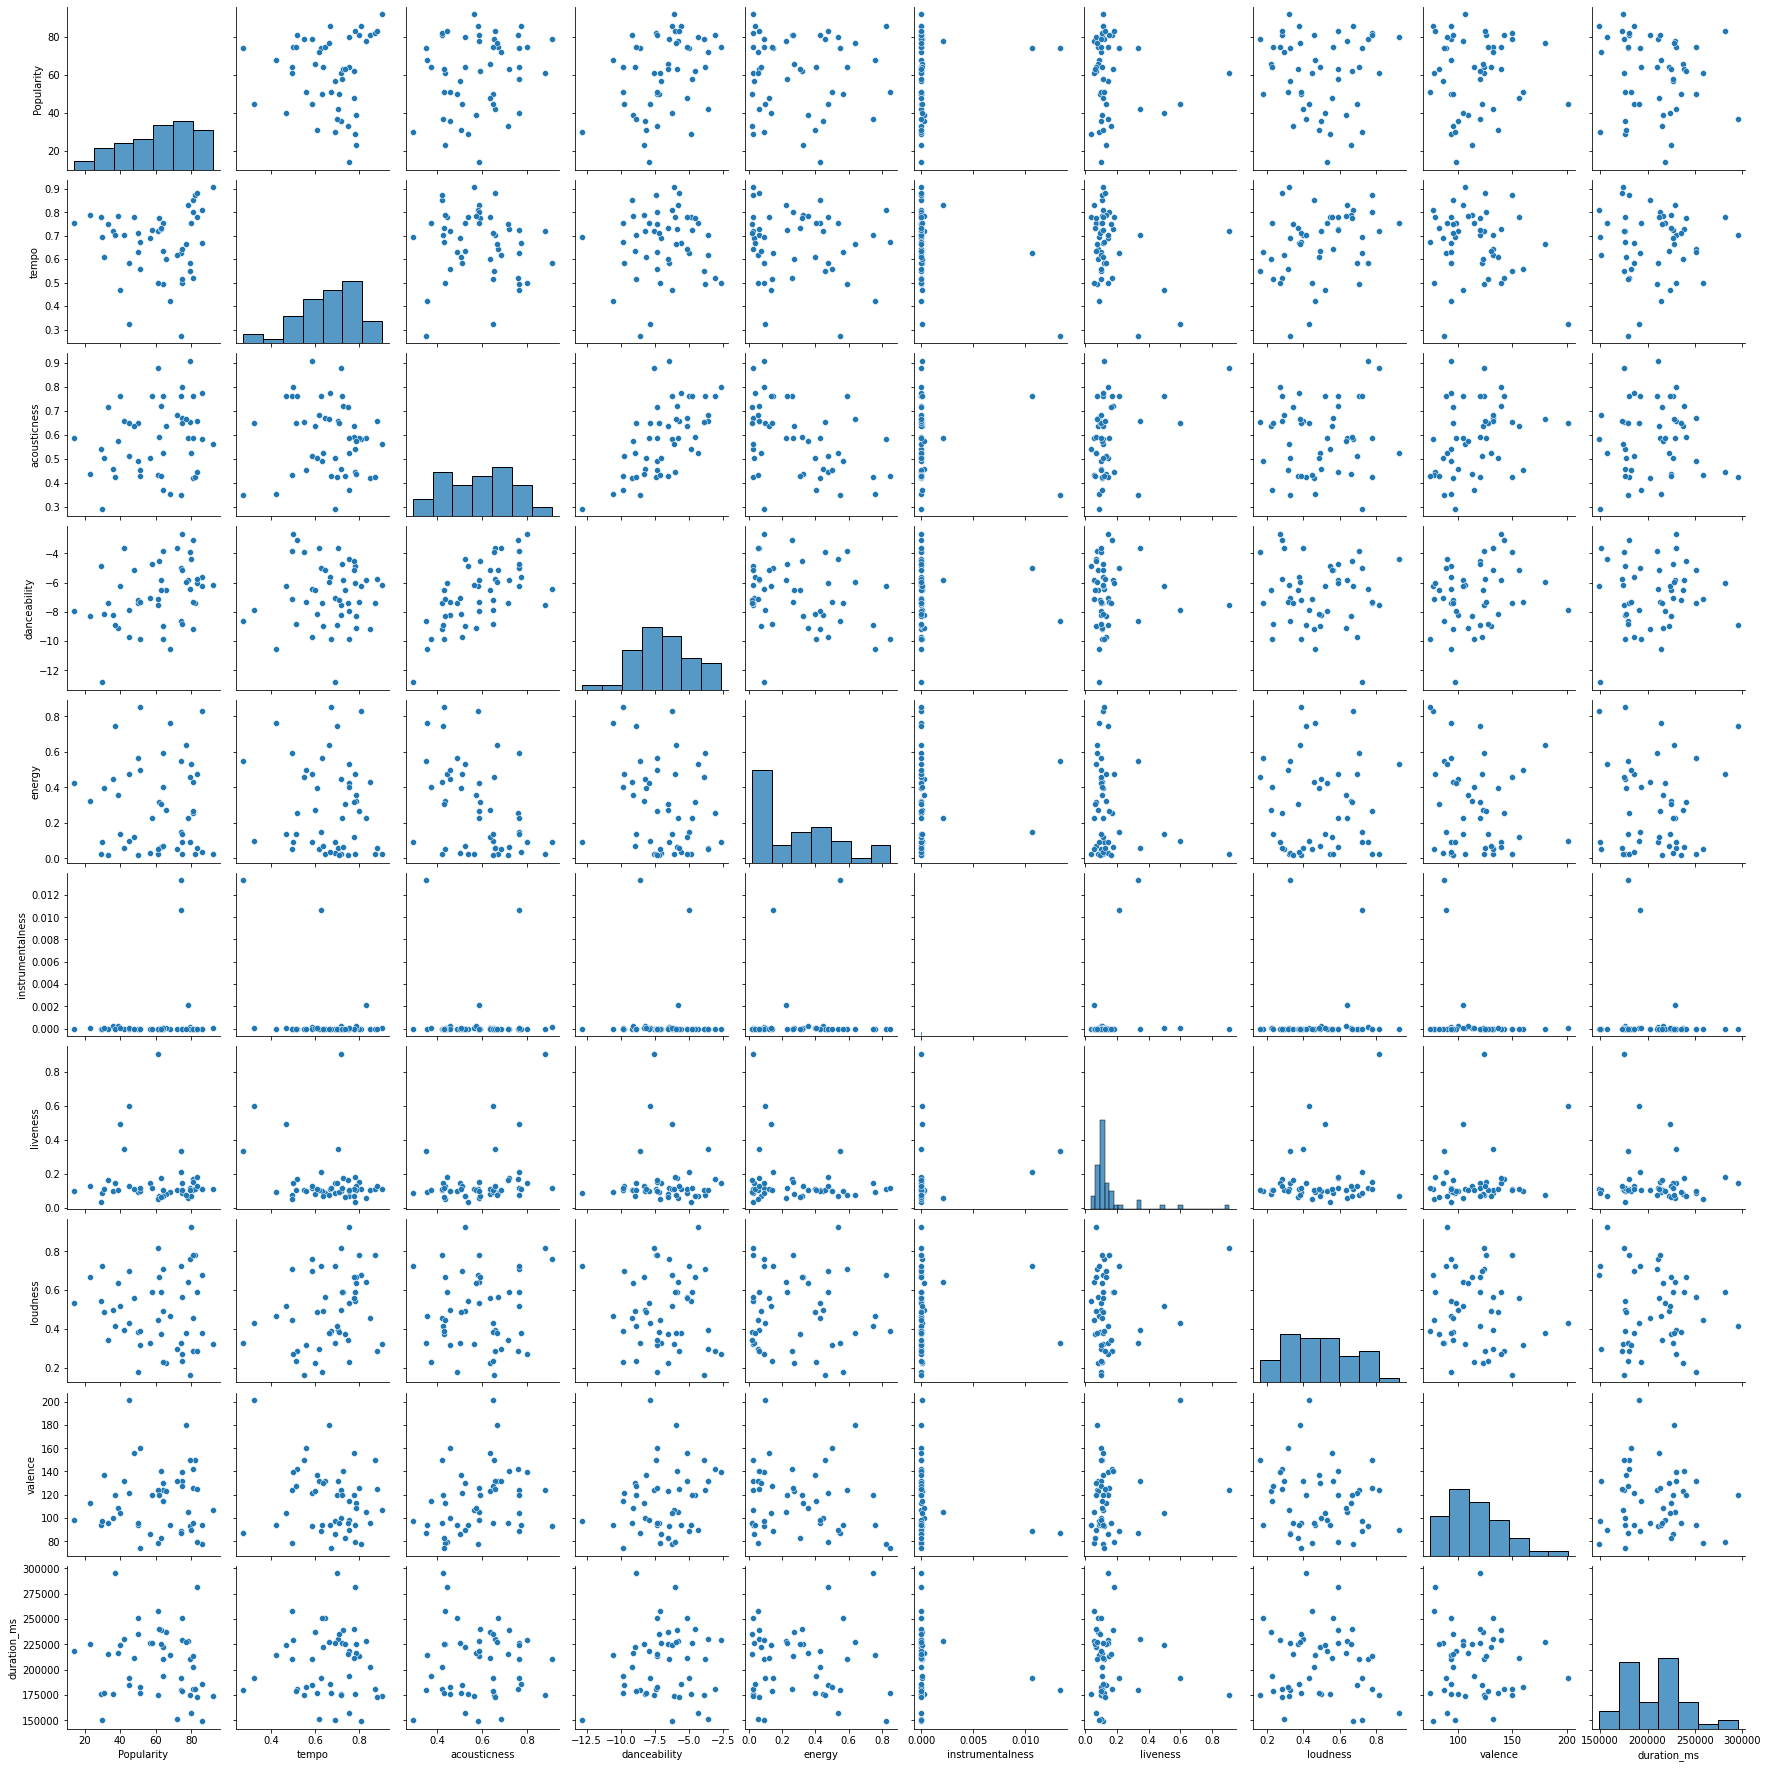

In [14]:
#to actually see the tendencies and possible linear correlation between features and in order to catch intuitively any possible 
#linear correlation between any pair of features we can plot with seabor a pairplot with the raw data
sns.pairplot(df)

As we can see in the plot above, due to the difference in scale of some of the features, the relation of certain pairs 
is difficult to catch geometricaly, specially in those relations that involve the instrumentalness.

If we were interested in see any pattern distribution of our data (due to some kind of structure in the population) such as groups that maybe formaing (for example, viewing if tracks of similar genres are groping together), we could apply some kind of cluster technique, for example, a k-means algorithm or even a dimension reduction such as principal component analysis (PCA), but for do so, and because of the differences in scale of the features we selected, it will be necessary to make some dicissions:

 * Eliminate those atributes that may affect the effectiveness of these algorithms
 
 
 * Transform  data in a certain way that makes this kind of algorithms work as good as possible.

In [15]:
#In this case we will slice the dataframe to create a numpy array with the variables (atributes) to scale, 
#in this case standardizing features by removing the mean and scaling to unit variance using the z score.

#Using a subset of all continious features (everythin except artis, track and popularity)
slicing_values = df.iloc[:, 3:].to_numpy()
new_values = StandardScaler().fit_transform(slicing_values)

In [16]:
scores_by_group={}
score_values=[]
labels = []
for i in range (2,8):
    kmeans=KMeans(n_clusters=i, random_state=0).fit(new_values)
    labels.append(kmeans.labels_)
    score=silhouette_score(new_values, kmeans.labels_)
    scores_by_group["{}_grupos".format(str(i))]=score
    print("Clusters formed {}, efficiency k {}".format(str(i), str(score)))
    

Clusters formed 2, efficiency k 0.15832373077201667
Clusters formed 3, efficiency k 0.17476842341207285
Clusters formed 4, efficiency k 0.16696221134926303
Clusters formed 5, efficiency k 0.14744168665602916
Clusters formed 6, efficiency k 0.13087629103990625
Clusters formed 7, efficiency k 0.1286351007856748


In [17]:
#Now we could apply a PCA and later on we can use the clusters formed by the k means algorithm for the best 'k' (3 clusters),
#in this case for 3 clusters, to represent the geometric distribution in a 2 dimension space:
pca = PCA(n_components=2)
components = pca.fit_transform(new_values)

#Extracting the variance explained by both of the new axis in % for a 2D reduction:
variance = {str(i): f"PC {i+1} ({var:.1f}%)" for i, var in enumerate(pca.explained_variance_ratio_ * 100)}

In [18]:
for v in variance.values():
    print(v)

PC 1 (24.5%)
PC 2 (17.5%)


In [19]:
d_aux = {
    'PCA_X':[x[0] for x in components], 
    'PCA_Y':[y[1] for y in components], 
    'K_GROUP':labels[1], 
    'Popularity': df['Popularity'].tolist()}

In [20]:
my_new_frame = pd.DataFrame.from_dict(d_aux)

In [21]:
my_new_frame.head()

,PCA_X,PCA_Y,K_GROUP,Popularity
0,1.412047,-0.519382,2,79
1,-2.782438,1.664335,0,68
2,-1.493636,0.008259,0,36
3,0.971866,0.160427,2,64
4,3.160437,1.090439,2,61


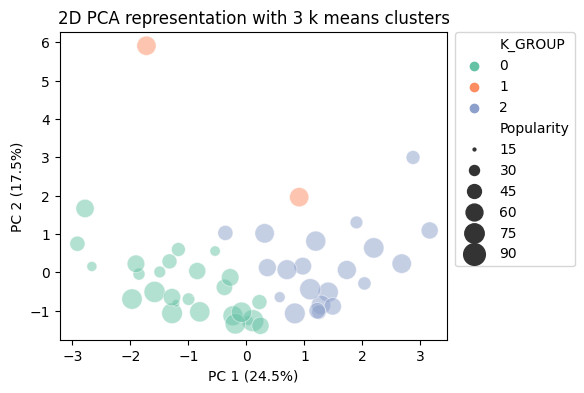

In [22]:
fig, ax = plt.subplots(figsize = (5,4))

sns.scatterplot(data=my_new_frame, 
                x = 'PCA_X', 
                y = 'PCA_Y', 
                hue = 'K_GROUP', 
                size = 'Popularity',
                sizes=(1, 250), 
                palette="Set2",
                alpha = .5,
                ax = ax)

plt.title('2D PCA representation with 3 k means clusters')
plt.xlabel('PC 1 (24.5%)')
plt.ylabel('PC 2 (17.5%)')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [23]:
#We can try a 3d decomposition only to take a geomatrically intuiation about a possible structure underlying the data:
pca_3d = PCA(n_components=3)
components_3d = pca_3d.fit_transform(new_values)

#Extracting the variance explained by both of the new axis in % for a 3D reduction:
variance_3d = {str(i): f"PC {i+1} ({var:.1f}%)" for i, var in enumerate(pca_3d.explained_variance_ratio_ * 100)}

In [24]:
for v in variance_3d.values():
    print(v)

PC 1 (24.5%)
PC 2 (17.5%)
PC 3 (14.5%)


In [25]:
d_aux_3d = {
    'PCA_X':[x[0] for x in components_3d], 
    'PCA_Y':[y[1] for y in components_3d],
    'PCA_Z':[z[2] for z in components_3d],
    'K_GROUP':labels[1], 
    'Popularity': df['Popularity'].tolist()}

In [26]:
my_new_3d_frame = pd.DataFrame.from_dict(d_aux_3d)

In [27]:
my_new_3d_frame.head()

,PCA_X,PCA_Y,PCA_Z,K_GROUP,Popularity
0,1.412047,-0.519382,1.236718,2,79
1,-2.782438,1.664335,-0.852382,0,68
2,-1.493636,0.008259,0.348901,0,36
3,0.971866,0.160427,-0.140935,2,64
4,3.160437,1.090439,3.660234,2,61


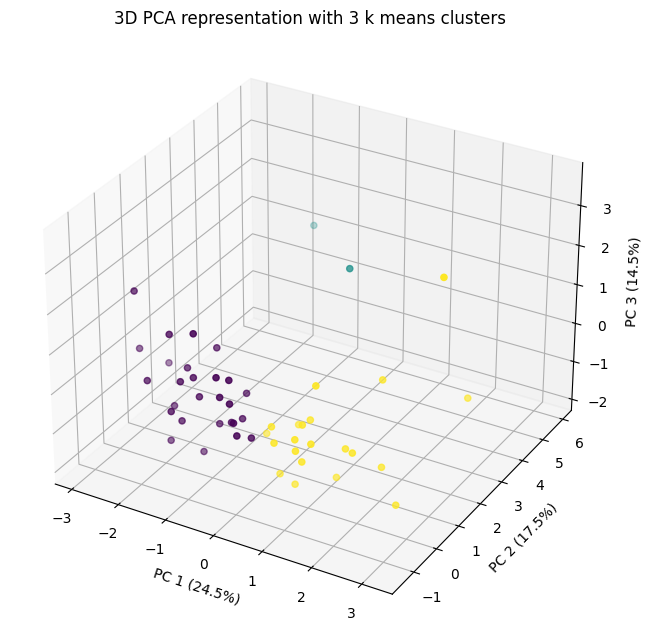

In [28]:
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig) 

ax.scatter(my_new_3d_frame['PCA_X'], 
           my_new_3d_frame['PCA_Y'], 
           my_new_3d_frame['PCA_Z'], 
           c = my_new_3d_frame['K_GROUP'],
           marker='o')

plt.title('3D PCA representation with 3 k means clusters')
ax.set_xlabel('PC 1 (24.5%)')
ax.set_ylabel('PC 2 (17.5%)')
ax.set_zlabel('PC 3 (14.5%)')
plt.show()